In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
nl = 0
basepath = f'../results/balanced_budgets/{nl}_lobbyists/'
filename = 'config.json'
with open(os.path.join(basepath, filename), 'r') as f:
    params = json.load(f)

In [7]:
print(params)

{'p_o': 0.01, 'p_p': 0.99, 'lambda_values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'phi_values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'T': 10000, 'n_lobbyists': 0, 'lobbyists_data': {}, 'nruns': 100}


In [8]:
p_o = params['p_o']
p_p = params['p_p']
lambda_values = params['lambda_values']
phi_values = params['phi_values']
n_lobbyists = params['n_lobbyists']
nruns = params['nruns']
lobbyists_data = params['lobbyists_data']

In [9]:
kinds = ['weights', 'probabilities']

data = []

for folder in os.listdir(basepath):
    paramspath = os.path.join(basepath, folder)
    try:
        lambda_v = float(folder.split('_')[0])  
        phi_v = float(folder.split('_')[1])
    except:
        continue
    
    for kind in kinds:   
        filename = os.path.join(paramspath, f'{kind}_average_metrics.json') 
        with open(filename, 'r') as f:
            avg_metrics = json.load(f)
                        
        columns = ['kind', 'n_lobbyists', 'lambda', 'phi', 'nruns', 'p_o', 'p_p']
        values = [kind, n_lobbyists, lambda_v, phi_v, nruns, p_o, p_p]
        
        for metric_name in avg_metrics.keys():
            if metric_name != 'lobbyists_performance':
                avg = avg_metrics[metric_name]['avg']
                std = avg_metrics[metric_name]['std']
                columns.extend([f'avg_{metric_name}', f'std_{metric_name}'])
                values.extend([avg, std])
            else:
                for id in lobbyists_data.keys():
                    print('entering here')
                    avg = avg_metrics[metric_name][id]['avg']
                    std = avg_metrics[metric_name][id]['std']
                    columns.extend([f'avg_{metric_name}_{id}', f'std_{metric_name}_{id}'])
                    values.extend([avg, std])
                            
        row = dict(zip(columns, values))
            
        data.append(row)
        
df = pd.DataFrame(data)
#datapath = os.path.join(basepath, 'aggregate_metrics.csv')        
#df.to_csv(datapath)

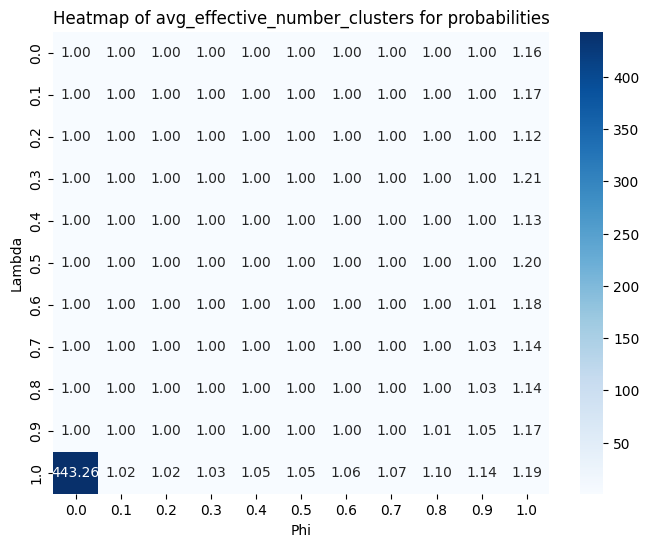

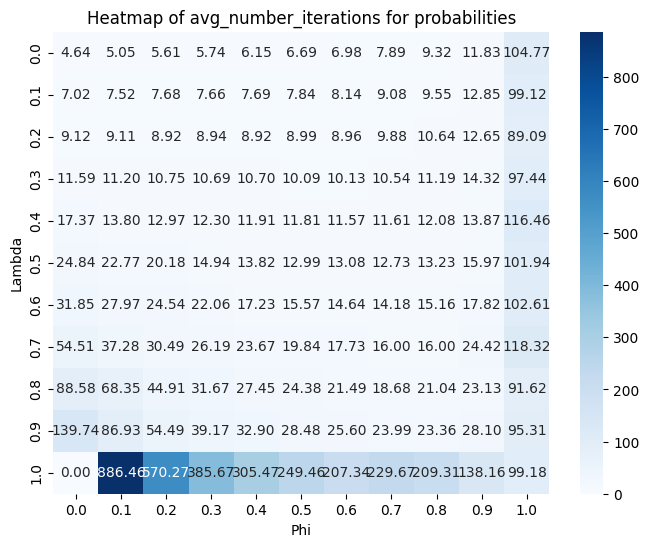

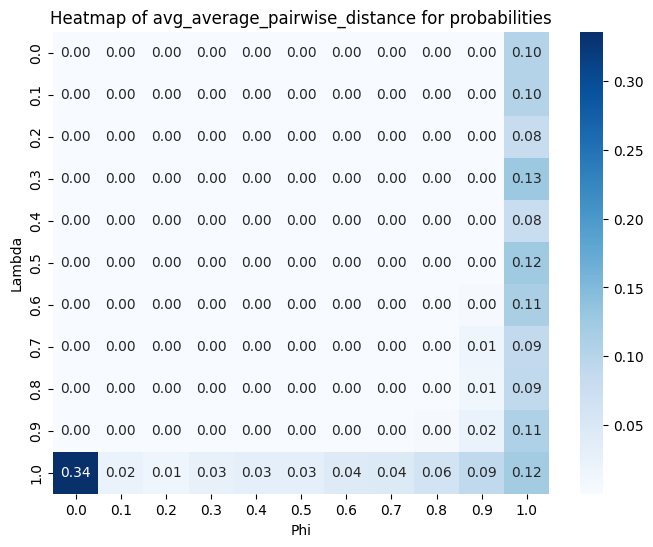

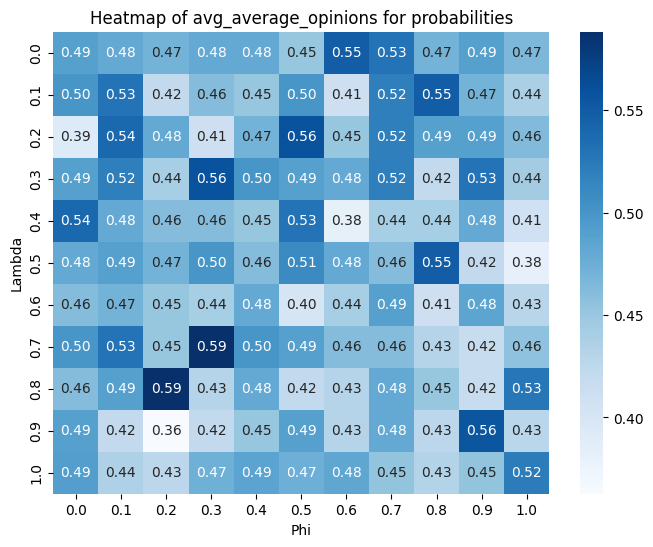

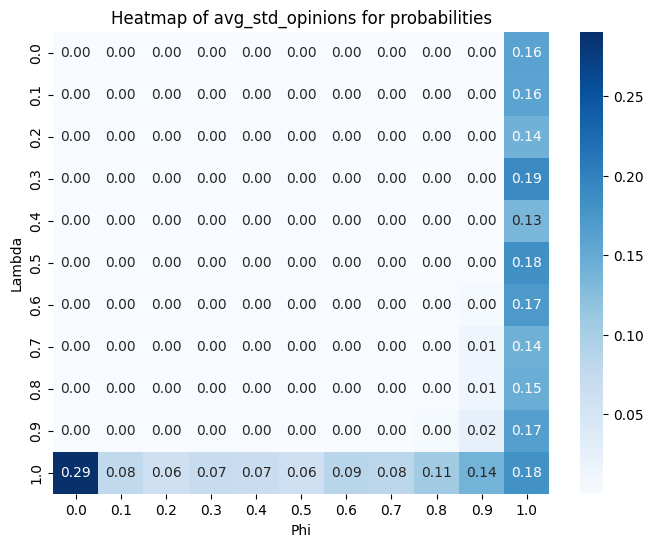

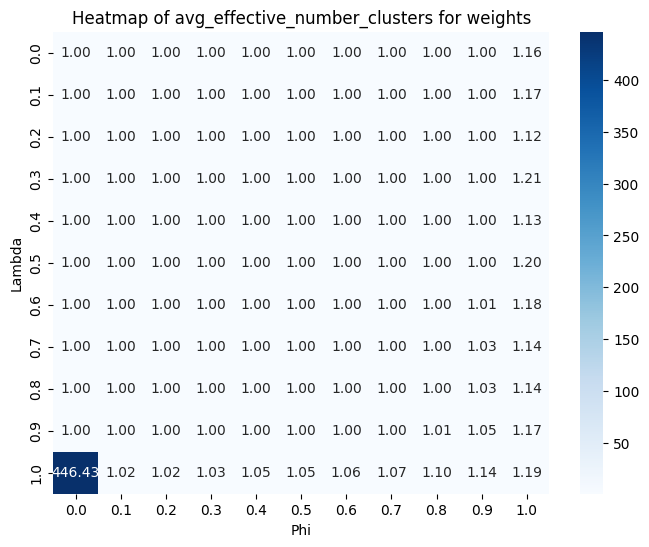

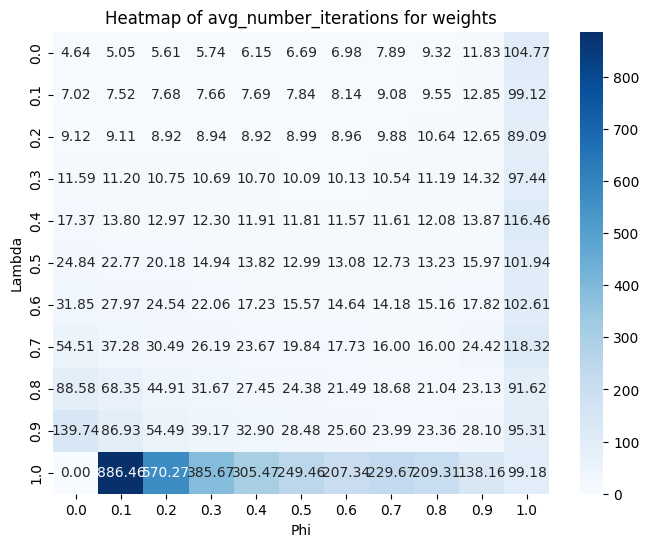

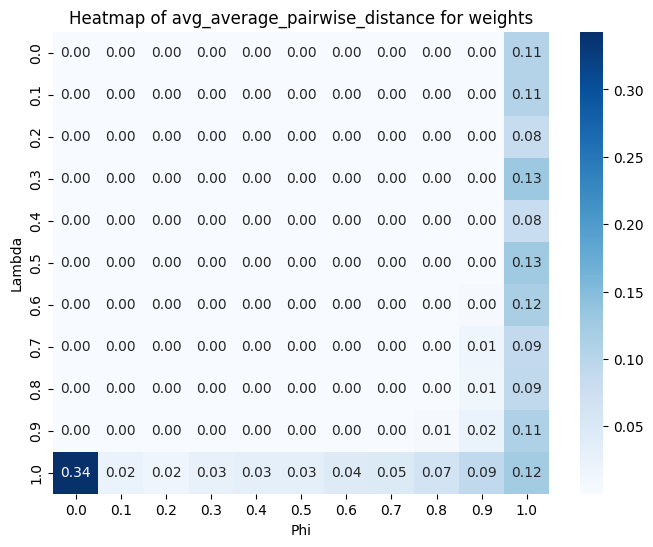

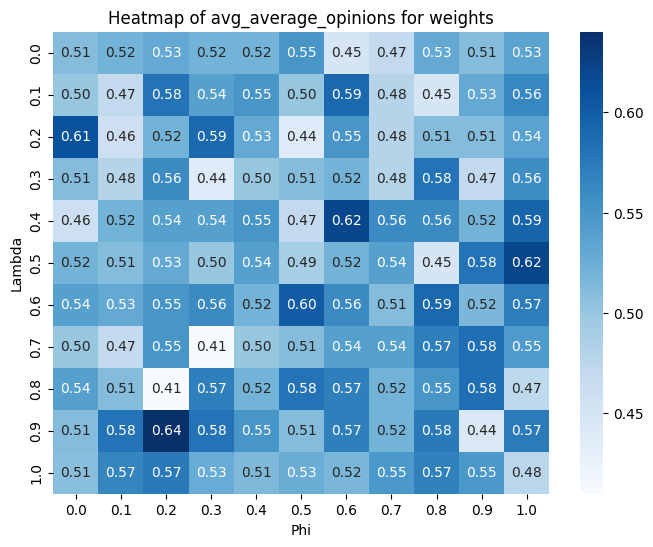

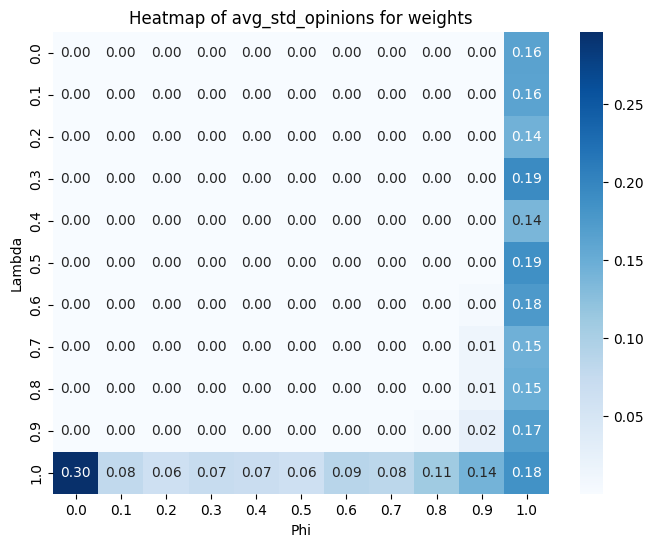

In [10]:
import seaborn as sns

def heatmap(kind, metric, figname=None):
    # Filter the DataFrame
    
    df_filtered = df[df["kind"] == kind]

    # Pivot the table to have phi and lambda as axes
    heatmap_data = df_filtered.pivot(index="lambda", columns="phi", values=metric)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt=".2f")
    plt.title(f"Heatmap of {metric} for {kind}")
    plt.xlabel("Phi")
    plt.ylabel("Lambda")
    figpath = os.path.join(basepath, 'figures')
    os.makedirs(figpath, exist_ok=True)
    
    if figname is not None:
        figname = os.path.join(figpath, figname)
        plt.savefig(figname, dpi=300, bbox_inches='tight', facecolor='white')
    else:
        plt.show()
        
    plt.close()


for kind in ['probabilities', 'weights']:
    for col in columns:
        if col.startswith('avg'):
            metric = col
            heatmap(kind, metric)

In [11]:
kinds = ['weights', 'probabilities']

data = []

for folder in os.listdir(basepath):
    paramspath = os.path.join(basepath, folder)
    try:
        lambda_v = float(folder.split('_')[0])  
        phi_v = float(folder.split('_')[1])
    except:
        continue
    
    for kind in kinds:   
        filename = os.path.join(paramspath, f'{kind}_metrics_distributions.json') 
        with open(filename, 'r') as f:
            metrics = json.load(f)
                       
        columns = ['kind', 'lambda', 'phi']
        values = [kind, lambda_v, phi_v]
        
        for metric_name in metrics.keys():
            if metric_name != 'lobbyists_performance':
                columns.append(metric_name)
                values.append(metrics[metric_name])
            else:
                for id in lobbyists_data.keys():
                    columns.append(f'{metric_name}_{id}')
                    values.append(metrics[metric_name][id])
                            
        row = dict(zip(columns, values))
            
        data.append(row)
        
df = pd.DataFrame(data)
#datapath = os.path.join(basepath, 'metrics_distributions.csv')
#df.to_csv(datapath)

In [12]:
df

,kind,lambda,phi,effective_number_clusters,number_iterations,average_pairwise_distance,average_opinions,std_opinions
0,weights,0.7,0.2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[31, 31, 29, 30, 30, 30, 30, 30, 30, 29, 34, 2...","[2.007269072485656e-06, 9.73518232188655e-07, ...","[0.9999972075839703, 0.9999990357030607, 3.065...","[1.887648896835685e-06, 1.032103493092555e-06,..."
1,probabilities,0.7,0.2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[31, 31, 29, 30, 30, 30, 30, 30, 30, 29, 34, 2...","[1.967123691035911e-06, 9.54047867544755e-07, ...","[0.010002736567709175, 0.010000945011000465, 0...","[1.8498959188989373e-06, 1.011461423230613e-06..."
2,weights,0.6,0.6,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14, 14, 14, 13, 15, 14, 15, 14, 14, 14, 14, 1...","[1.268365705833726e-07, 1.2220010803843385e-07...","[0.9999999249502027, 0.9999999272297978, 5.299...","[3.221897311113004e-07, 3.098375162151729e-07,..."
3,probabilities,0.6,0.6,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14, 14, 14, 13, 15, 14, 15, 14, 14, 14, 14, 1...","[1.2429983917171472e-07, 1.1975610587765805e-0...","[0.010000073548801319, 0.010000071314798074, 0...","[3.1574593648908935e-07, 3.036407658908689e-07..."
4,weights,0.0,0.4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, ...","[3.3700007334388507e-08, 5.776863255963848e-09...","[0.9999999829350232, 3.093010635160891e-09, 0....","[2.7999360692458507e-07, 2.6214922533286532e-0..."
...,...,...,...,...,...,...,...,...
237,probabilities,0.5,0.7,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[11, 11, 16, 11, 12, 12, 13, 11, 12, 11, 11, 1...","[2.2149415105843294e-07, 2.226312204054417e-07...","[0.98999986929341, 0.9899998689117808, 0.01000...","[4.017562391986201e-07, 4.077089601086119e-07,..."
238,weights,0.0,0.1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5.0222301160593355e-08, 3.662448195642369e-08...","[0.9999999742669928, 0.9999999811087558, 4.299...","[3.132510059123665e-07, 2.813873120523273e-07,..."
239,probabilities,0.0,0.1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[4.92178551373308e-08, 3.589199231725377e-08, ...","[0.010000025218347102, 0.010000018513419468, 0...","[3.069859857941644e-07, 2.757595658113344e-07,..."
240,weights,1.0,0.2,"[1.0242879150414632, 1.0703062788447542, 1.008...","[718, 718, 236, 623, 809, 710, 296, 871, 178, ...","[0.023759158543162785, 0.06581944952295705, 0....","[0.011999816906675849, 0.033999898754016926, 0...","[0.10888359937320558, 0.1812285970725121, 0.06..."


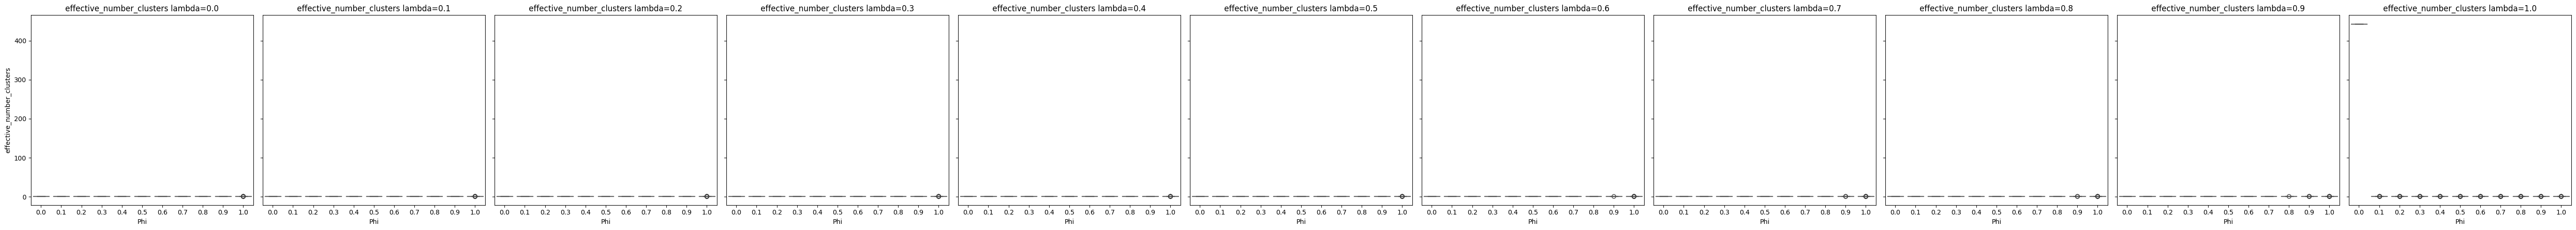

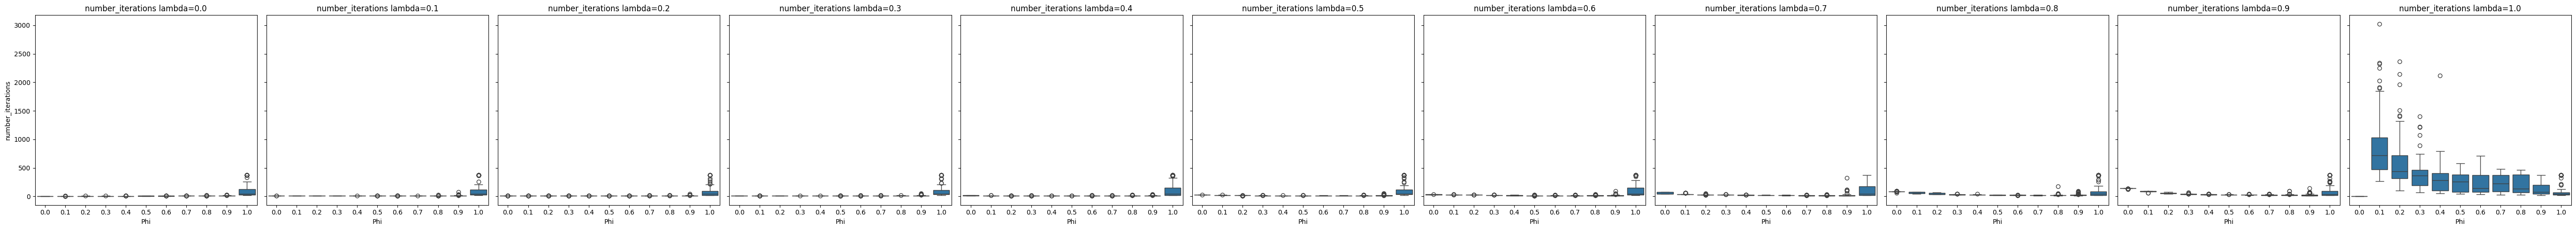

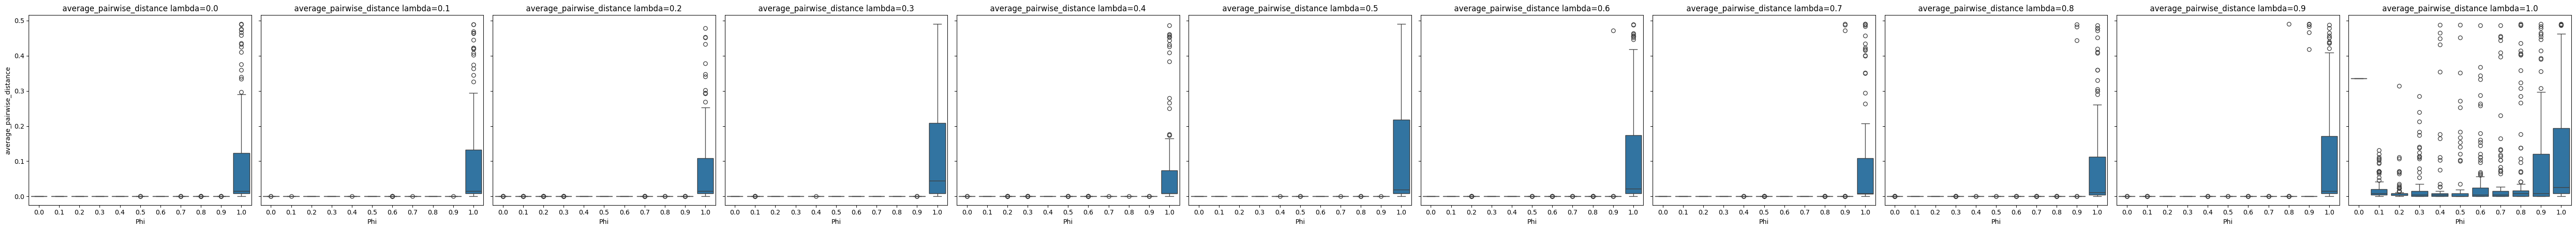

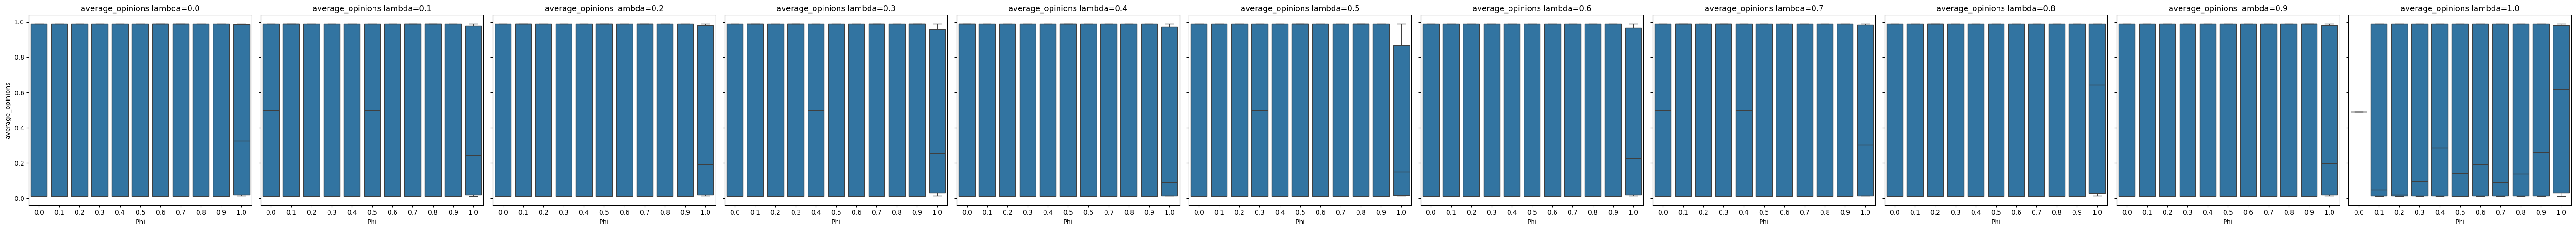

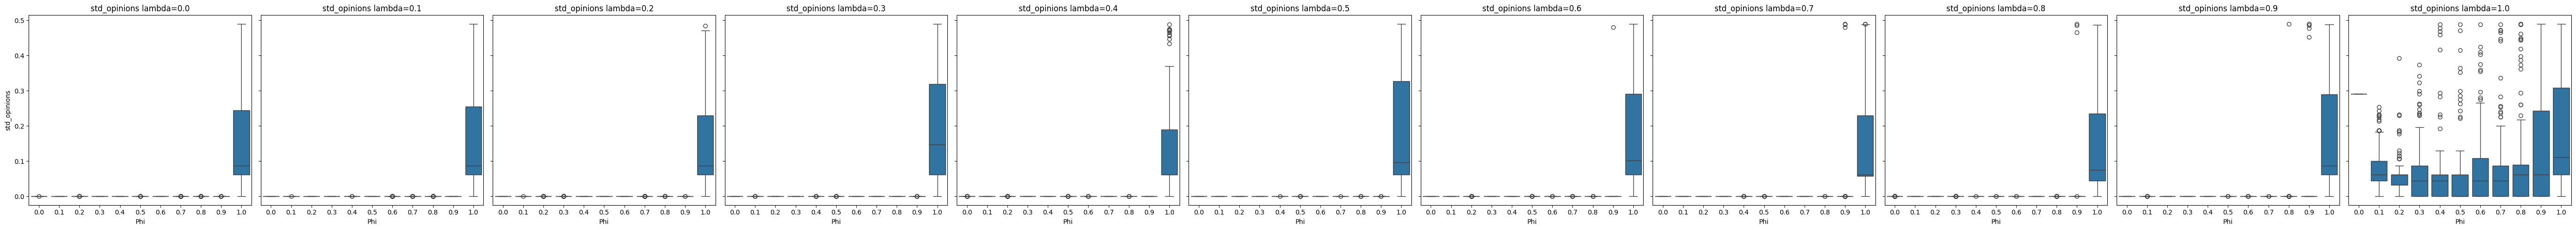

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def explode_lists(df):
    """Expands list values into separate rows while keeping other columns unchanged."""
    id_vars = ["kind", "lambda", "phi"]
    value_vars = [col for col in df.columns if col not in id_vars]
    
    exploded_data = []
    for _, row in df.iterrows():
        max_len = max(len(row[col]) for col in value_vars)
        for i in range(max_len):
            exploded_row = {col: row[col] if col in id_vars else row[col][i] for col in df.columns}
            exploded_data.append(exploded_row)
    
    return pd.DataFrame(exploded_data)

def plot_metrics_grid(df):
    df = explode_lists(df)
    metrics = [col for col in df.columns if col not in ["kind", "lambda", "phi"]]
    lambda_values = sorted(df["lambda"].unique())
    num_lambdas = len(lambda_values)
    
    kind = 'probabilities'
    df_kind = df[df["kind"] == kind]
    for metric in metrics:
        fig, axes = plt.subplots(1, num_lambdas, figsize=(5 * num_lambdas, 5), sharey=True)
        
        if num_lambdas == 1:
            axes = [axes]  # Ensure axes is iterable if only one lambda value exists
        
        for i, lambd in enumerate(lambda_values):
            ax = axes[i]
            subset = df_kind[df_kind["lambda"] == lambd]
            
            sns.boxplot(x="phi", y=metric, data=subset, ax=ax)
            ax.set_title(f"{metric} lambda={lambd}")
            ax.set_xlabel("Phi")
            ax.set_ylabel(metric)
        
        plt.tight_layout()
        figpath = os.path.join(basepath, 'figures')
        os.makedirs(figpath, exist_ok=True)
        figname = os.path.join(figpath, f'boxplots_{metric}.png')
        #plt.savefig(figname, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        plt.close()

# Example usage
#df = pd.read_csv(datapath)  # Load the DataFrame from CSV or other sources
plot_metrics_grid(df)
